In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

nltk_data = ['punkt', 'stopwords', 'wordnet', 'punkt_tab']
for d in nltk_data:
    nltk.download(d, quiet=True)

In [39]:
# Data configurations
MAX_FEATURES = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2

# Model configurations
LSTM_UNITS = 128
GRU_UNITS = 128
DROPOUT_RATE = 0.3
BATCH_SIZE = 64
EPOCHS = 10

class ModelType(Enum):
    SVM = 'SVM'
    DECISION_TREE = 'Decision Tree'
    LSTM = 'LSTM'
    BI_LSTM = 'Bi-LSTM'
    BI_GRU = 'Bi-GRU'

class Classification(Enum):
    HATE_SPEECH = 'Hate Speech'
    OFFENSIVE = 'Offensive Language'
    NEITHER = 'Neither'

In [40]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.tokenizer = None
        self.tfidf_vectorizer = None

    def clean_text(self, text):
        text = str(text).lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove user mentions
        text = re.sub(r'@\w+', '', text)
        # Remove hashtags
        text = re.sub(r'#\w+', '', text)
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        
        tokens = word_tokenize(text)
        # Remove stopwords and lemmatize
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens 
                 if token not in self.stop_words]
        
        return ' '.join(tokens)

    def prepare_data(self, df, text_column, label_column):
        df['cleaned_text'] = df[text_column].apply(self.clean_text)
        
        # Create TF-IDF vectors
        self.tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(df['cleaned_text'])
        
        # Create tokenizer for deep learning models
        self.tokenizer = Tokenizer(num_words=MAX_FEATURES)
        self.tokenizer.fit_on_texts(df['cleaned_text'])
        
        # Convert text to sequences
        X_seq = self.tokenizer.texts_to_sequences(df['cleaned_text'])
        X_pad = pad_sequences(X_seq, maxlen=MAX_LEN)
        y = df[label_column]
        
        X_train_pad, X_temp_pad, X_train_tfidf, X_temp_tfidf, y_train, y_temp = train_test_split(
            X_pad, tfidf_matrix, y, test_size=TEST_SPLIT + VALIDATION_SPLIT, random_state=42
        )
        
        X_val_pad, X_test_pad, X_val_tfidf, X_test_tfidf, y_val, y_test = train_test_split(
            X_temp_pad, X_temp_tfidf, y_temp, 
            test_size=TEST_SPLIT/(TEST_SPLIT + VALIDATION_SPLIT), 
            random_state=42
        )
        
        return (X_train_pad, X_val_pad, X_test_pad, 
                X_train_tfidf, X_val_tfidf, X_test_tfidf, 
                y_train, y_val, y_test)

In [4]:
# Load dataset
# https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset

df = pd.read_csv("dataset/labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [41]:
# Prepare Data
preprocessor = TextPreprocessor()
(X_train_pad, X_val_pad, X_test_pad,
 X_train_tfidf, X_val_tfidf, X_test_tfidf,
 y_train, y_val, y_test) = preprocessor.prepare_data(df, 'tweet', 'class')

print("Data preparation completed!")
print(f"Training set size: {len(X_train_pad)}")
print(f"Validation set size: {len(X_val_pad)}")
print(f"Test set size: {len(X_test_pad)}")

Data preparation completed!
Training set size: 14869
Validation set size: 4957
Test set size: 4957


In [44]:
# Traditional Models
def traditional_models():
    models = {
        'SVM': SVC(kernel='linear', random_state=42, probability=True),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        model = model.fit(X_train_tfidf, y_train)
        predictions = model.predict(X_test_tfidf)
        
        results[name] = {
            'accuracy': accuracy_score(y_test, predictions),
            'precision': precision_score(y_test, predictions, average='weighted'),
            'recall': recall_score(y_test, predictions, average='weighted'),
            'f1_score': f1_score(y_test, predictions, average='weighted')
        }
        
    return models, results

traditional_models, traditional_results = traditional_models()


Training SVM...

Training Decision Tree...


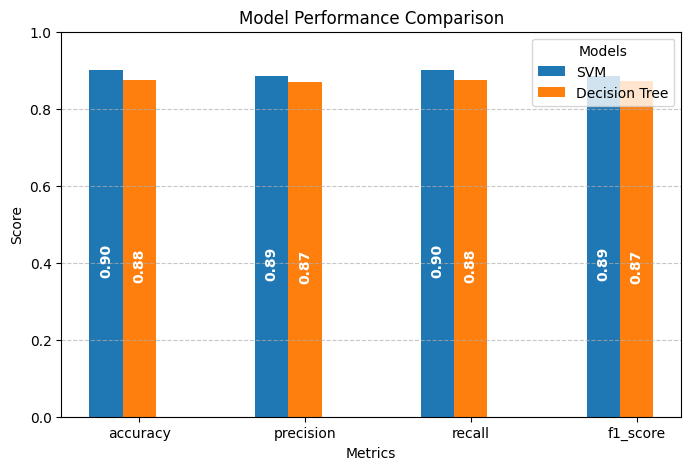

In [51]:
# Evaluation of traditional models
df_traditional_results = pd.DataFrame.from_dict(traditional_results, orient='index')
df_traditional_results = df_traditional_results.T

bar_width = 0.2
x = np.arange(len(df_traditional_results.index))
plt.figure(figsize=(8, 5))
for i, model in enumerate(df_traditional_results.columns):
    bars = plt.bar(x + i * bar_width, df_traditional_results[model], width=bar_width, label=model)
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            f"{height:.2f}",
            ha='center', va='top', fontsize=10, color='white', fontweight='bold', rotation=90
        )

plt.xticks(x + bar_width, df_traditional_results.index)
plt.title("Model Performance Comparison")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Models")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [54]:
# Deep Learning models
def create_deep_learning_models():
    vocab_size = len(preprocessor.tokenizer.word_index) + 1

    models = {
        ModelType.LSTM: Sequential([
            Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
            LSTM(LSTM_UNITS, return_sequences=True),
            LSTM(LSTM_UNITS),
            Dropout(DROPOUT_RATE),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')
        ]),
        ModelType.BI_LSTM: Sequential([
            Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
            Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
            Bidirectional(LSTM(LSTM_UNITS)),
            Dropout(DROPOUT_RATE),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')
        ]),
        ModelType.BI_GRU: Sequential([
            Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
            Bidirectional(GRU(GRU_UNITS, return_sequences=True)),
            Bidirectional(GRU(GRU_UNITS)),
            Dropout(DROPOUT_RATE),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')
        ])
    }
    
    for name, model in models.items():
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return models


dl_models = create_deep_learning_models()
dl_results = {}
dl_histories = {}

for name, model in dl_models.items():
    print(f"Training {name.value}")
    dl_histories[name] = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test_pad, y_test)
    print(f"{name.value} Test Accuracy: {test_acc:.4f}")

    predictions_prob = model.predict(X_test_pad)
    predictions = np.argmax(predictions_prob, axis=1)

    dl_results[name.value] = {
        'accuracy': accuracy_score(y_test, predictions),
        'precision': precision_score(y_test, predictions, average='weighted'),
        'recall': recall_score(y_test, predictions, average='weighted'),
        'f1': f1_score(y_test, predictions, average='weighted'),
    }    

Training LSTM
Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 106s 450ms/step - accuracy: 0.7816 - loss: 0.6368 - val_accuracy: 0.8864 - val_loss: 0.3400
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 114s 488ms/step - accuracy: 0.9073 - loss: 0.2891 - val_accuracy: 0.8899 - val_loss: 0.3031
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 109s 468ms/step - accuracy: 0.9359 - loss: 0.1889 - val_accuracy: 0.8905 - val_loss: 0.3016
Epoch 4/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 109s 468ms/step - accuracy: 0.9562 - loss: 0.1348 - val_accuracy: 0.8636 - val_loss: 0.4078
Epoch 5/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 98s 421ms/step - accuracy: 0.9656 - loss: 0.1019 - val_accuracy: 0.8814 - val_loss: 0.4365
Epoch 6/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 92s 393ms/step - accuracy: 0.9729 - loss: 0.0709 - val_accuracy: 0.8719 - val_loss: 0.5081
Epoch 7/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 91s 391ms/step - accuracy: 0.9767 - loss: 0.0649 - val_accuracy: 0.8608 - val_loss: 0.6117
Epoch 8/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 104s 446ms/step - accurac

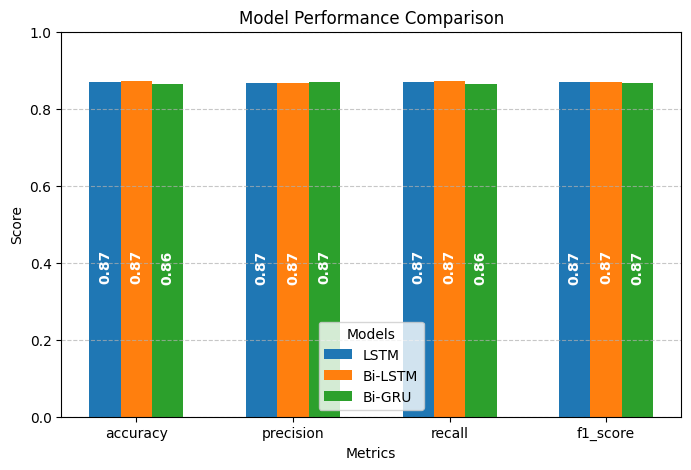

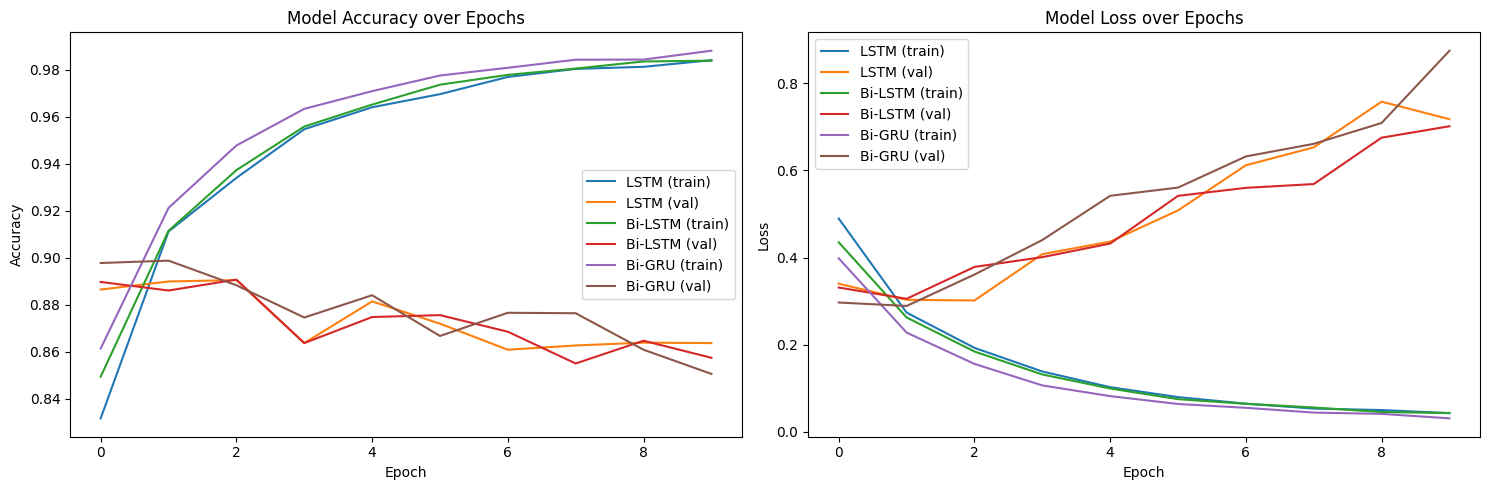

In [60]:
# Evaluation of deep learning models
df_dl_results = pd.DataFrame.from_dict(dl_results, orient='index')
df_dl_results = df_dl_results.T

bar_width = 0.2
x = np.arange(len(df_dl_results.index))
plt.figure(figsize=(8, 5))
for i, model in enumerate(df_dl_results.columns):
    bars = plt.bar(x + i * bar_width, df_dl_results[model], width=bar_width, label=model)
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            f"{height:.2f}",
            ha='center', va='top', fontsize=10, color='white', fontweight='bold', rotation=90
        )

plt.xticks(x + bar_width, df_traditional_results.index)
plt.title("Model Performance Comparison")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Models")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Plots for training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))    
for model_name, history in dl_histories.items():
    ax1.plot(history.history['accuracy'], label=f'{model_name.value} (train)')
    ax1.plot(history.history['val_accuracy'], label=f'{model_name.value} (val)')

ax1.set_title('Model Accuracy over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

for model_name, history in dl_histories.items():
    ax2.plot(history.history['loss'], label=f'{model_name.value} (train)')
    ax2.plot(history.history['val_loss'], label=f'{model_name.value} (val)')

ax2.set_title('Model Loss over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [38]:
# Analysis on real tweets (not part of the dataset)

In [85]:
class TweetAnalyzer:
    def __init__(self, preprocessor, traditional_models, dl_models):
        self.preprocessor = preprocessor
        self.traditional_models = traditional_models
        self.dl_models = dl_models
        self.label_map = {
            0: Classification.HATE_SPEECH.value,
            1: Classification.OFFENSIVE.value,
            2: Classification.NEITHER.value
        }

    def analyze_tweet(self, tweet: str, model_type: ModelType = None):
        # Clean and preprocess tweet
        cleaned_tweet = self.preprocessor.clean_text(tweet)
        
        tweet_tfidf = self.preprocessor.tfidf_vectorizer.transform([cleaned_tweet])
        sequence = self.preprocessor.tokenizer.texts_to_sequences([cleaned_tweet])
        padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN)
        
        results = []
        
        if model_type is None:
            # Use all models
            for name, model in self.traditional_models.items():
                pred = model.predict_proba(tweet_tfidf)[0]
                results.append({
                    'model': name,
                    'probabilities': {
                        self.label_map[i]: float(p) for i, p in enumerate(pred)
                    },
                    'predicted_class': self.label_map[np.argmax(pred)],
                    'confidence': float(max(pred))
                })
                
            for name, model in self.dl_models.items():
                pred = model.predict(padded_sequence, verbose=0)[0]
                results.append({
                    'model': name.value,
                    'probabilities': {
                        self.label_map[i]: float(p) for i, p in enumerate(pred)
                    },
                    'predicted_class': self.label_map[np.argmax(pred)],
                    'confidence': float(max(pred))
                })
        else:
            if model_type in [ModelType.SVM, ModelType.DECISION_TREE]:
                model = self.traditional_models[model_type.value]
                pred = model.predict_proba(tweet_tfidf, verbose=0)[0]
            else:
                model = self.dl_models[model_type]
                pred = model.predict(padded_sequence)[0]
            
            results.append({
                'model': model_type.value,
                'probabilities': {
                    self.label_map[i]: float(p) for i, p in enumerate(pred)
                },
                'predicted_class': self.label_map[np.argmax(pred)],
                'confidence': float(max(pred))
            })
        
        return results

    def visualize_analysis(self, results: list):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        
        # Plot 1: Overall predictions with confidence
        models = [r['model'] for r in results]
        confidences = [r['confidence'] for r in results]
        
        # Color mapping for different classifications
        color_map = {
            Classification.HATE_SPEECH.value: 'red',
            Classification.OFFENSIVE.value: 'orange',
            Classification.NEITHER.value: 'green'
        }
        
        colors = [color_map[r['predicted_class']] for r in results]
        
        bars1 = ax1.bar(models, confidences, color=colors)
        ax1.set_title('Model Predictions and Confidence')
        ax1.set_xlabel('Model')
        ax1.set_ylabel('Confidence')
        ax1.set_ylim(0, 1)
        
        # Add labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2%}',
                    ha='center', va='bottom')
        
        # Plot 2: Probability distribution for each class
        x = np.arange(len(models))
        width = 0.25
        
        # Plot probabilities for each class
        for i, class_type in enumerate(self.label_map.values()):
            probs = [r['probabilities'][class_type] for r in results]
            ax2.bar(x + i*width, probs, width, label=class_type)
        
        ax2.set_title('Probability Distribution by Class')
        ax2.set_xlabel('Model')
        ax2.set_ylabel('Probability')
        ax2.set_xticks(x + width)
        ax2.set_xticklabels(models, rotation=45)
        ax2.legend()
        ax2.set_ylim(0, 1)
        
        plt.suptitle(f'Analysis', fontsize=12)
        plt.tight_layout()
        plt.show()


# Utility function to print the results in a table
def results_as_table(data):
    # Extract unique models dynamically
    models = set()
    for tweets in data.values():
        for entry in tweets:
            for result in entry['result']:
                models.add(result['model'])
    models = sorted(models)

    # Prepare MultiIndex columns
    columns = [("Category", ""), ("Tweet", "")]
    for model in models:
        columns.extend([
            (model, "Hate"),
            (model, "Offensive"),
            (model, "Neither"),
            (model, "Predicted")
        ])

    rows = []
    for category, tweets in data.items():
        for entry in tweets:
            tweet_text = entry['tweet']
            row = [category, tweet_text]
            model_results = {r['model']: r for r in entry['result']}
            for model in models:
                if model in model_results:
                    probabilities = model_results[model]['probabilities']
                    predicted_class = model_results[model]['predicted_class']
                    row.extend([
                        f"{probabilities.get('Hate Speech', 0.0):.2f}",
                        f"{probabilities.get('Offensive Language', 0.0):.2f}",
                        f"{probabilities.get('Neither', 0.0):.2f}",
                        predicted_class
                    ])
                else:
                    # If model result is missing
                    row.extend(["-", "-", "-", "-"])
    
            rows.append(row)

    multi_index = pd.MultiIndex.from_tuples(columns)
    return pd.DataFrame(rows, columns=multi_index)

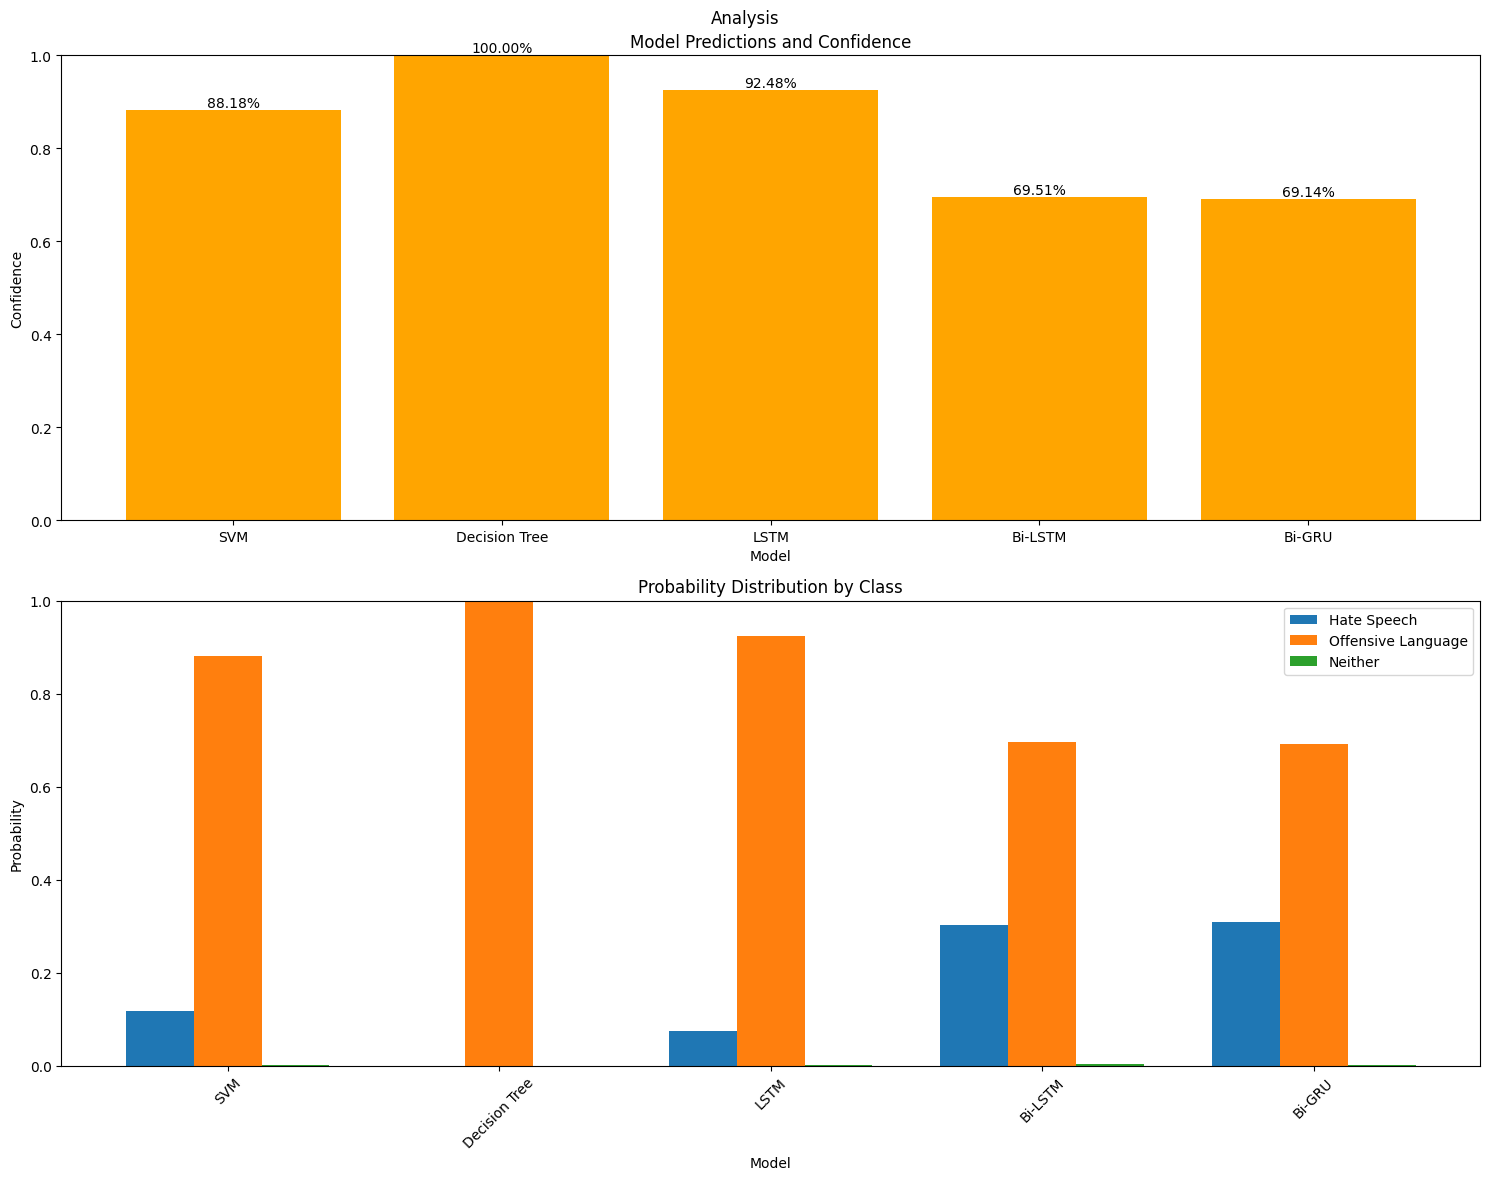

In [90]:
# Can also use the pre-trained models from the pre-trained directory.
cases = {
    'clean': [
        "Have a great day everyone! Spreading love and positivity.",
        "The weather is beautiful today, perfect for a walk.",
        "I really enjoyed reading that book, very insightful."
    ],
    'mild': [
        "I disagree with your opinion, it's not well thought out.",
        "This service is really disappointing.",
        "You're not making any sense right now."
    ],
    'moderate': [
        "All asians should be deported, they don't belong here.",
        "Women are inferior and shouldn't be allowed to work.",
        "People of christanity are all terrorists and should be banned."
    ],
    'strong': [
        "I'm going to find you and hurt you badly.",
        "All aethists deserve to die painfully.",
        "Someone should bomb their entire community."
    ],
    'severe': [
        "fuck you and everything you stand for!",
        "You're nothing but a hoe.",
        "Go fuck yourself, you cunt."
    ]
}

import os
import tensorflow as tf
from IPython.core.display import HTML

tf.get_logger().setLevel('ERROR')

analyzer = TweetAnalyzer(preprocessor, traditional_models, dl_models)
results = {}
for category in cases:
    results[category] = []
    for tweet in cases[category]:
         results[category].append({
             'tweet': tweet,
             'result': 2
         })

display(HTML(results_as_table(results).to_html(notebook=True,border=1)))


# Visualize results for one tweet
analyzer.visualize_analysis(results['severe'][2]['result'])